# アナグリフ方式で立体画像を作ろう

少し大変ですが、基礎的な画像処理でできるので、アナグリフ方式の立体画像を作ってみましょう

方針は以下の通りです。

1. 入力画像をRGBからHSVに変換する
1. 前景領域（手前に浮かび出したい領域）を抽出する  
    1. 今回はHSVにおける色相空間で赤色付近の領域を取り出すことで、赤茶色の安田講堂領域を抽出します
    1. 安田講堂のうちレンガではない部分は抽出できないので穴が開きます。そこで、安田講堂部分を包含する輪郭線を抽出し、その中を抜き出します。
1. 入力画像を前景領域と背景領域に分離します
1. 前景領域を赤とシアンに分離し、赤のほうを右に少しだけずらします
1. 背景領域と前景赤画像（ずらしたもの）と前景シアン画像を合成します




## 1. 入力画像をRGBからHSVに変換

まずは元の画像を見て見ましょう。おなじみの安田講堂ですね。   
すでに説明した通り、opencvで画像を読み込むと、RGBではなくBGRの順番になりますので、
cv2.cvtColorでBGRをRGBに変換するのを忘れないようにしましょう。

uint8
(696, 1200, 3)


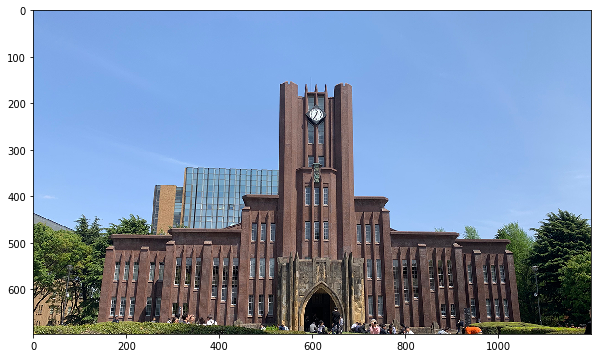

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2

img_org = cv2.imread('img/UTokyoYasudaCroppedMini.jpg')
img_org= cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,10))
plt.imshow(img_org)
print(img_org.dtype)
print(img_org.shape)

## 2. 前景領域（手前に出したい領域）を抽出する
### 2.1 色相空間で赤色付近の領域を取り出す

RGB色空間をHSV色空間に変換するにはcv2.cvtConvertでcv2.COLOR_RGB2HSVのフラグをセットします。   
RGB画像は0チャンネルがR (0-255),1チャンネルがG (0-255)、2チャンネルがB (0-255)でしたが、   
HSV画像では0チャンネルがH (0-179),1チャンネルがS (0-255)、2チャンネルが (0-255)です。


Text(0.5, 1.0, 'H image')

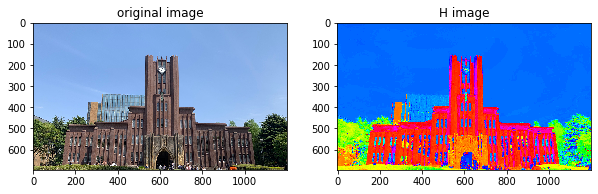

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np

# まずは原画像を表示しましょう
img_org = cv2.imread('img/UTokyoYasudaCroppedMini.jpg')
img_rgb= cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.imshow(img_rgb)
plt.title('original image')

# 色相空間の画像を見て見ましょう
img_hsv= cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV) # HSV画像に変換
img_h = np.zeros_like(img_rgb) # img_rgbと同じサイズで、値がすべて0の行列を作ります
img_h[:,:,0] = img_hsv[:,:,0] # 色相空間である0チャネルを代入
img_h[:,:,1] = 255*np.ones(img_hsv[:,:,1].shape, np.uint8) # 彩度はすべて255
img_h[:,:,2] = 255*np.ones(img_hsv[:,:,2].shape, np.uint8) # 明度もすべて255
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(img_h, cv2.COLOR_HSV2RGB)) # HSV画像をRGB画像に戻してから表示
plt.title('H image')



色相画像を見てみると、時計台の領域の色相は赤のようです。   
HSVのカラーマップを見ると、色相空間において赤は0度付近にあります。   
すなわち、0度に近い小さな値、あるいは179度に近い大きな値ということになります。  

<img src="img/HSV_cone.jpg" width=240>   
[Wikipedia:File:HSV cone.jpg](https://commons.wikimedia.org/wiki/File:HSV_cone.jpg) より引用

また、レンガはくすんだ色なので、彩度は低そう。ですが、0に近いと色相は無関係になるので、0近辺は除くべきです。   
明度は、物体そのものの色ではなく、光の当たり具合（影）によって変わる空間と言われており、
HSV色空間で色による領域抽出をする際は無視されることが多いです。

色相（H)と値の関係は以下の通りです。色相は0～179の値をとります   
（本来ならば360度による角度で表されるものですが、今回の画像形式は256までしか表現できないため、   
2度を1階調とする形式になっています）。   
<img src="img/HSV_colormap.png" width=480>   

ということで、色相（H)が30よりも小さい、あるいは160よりも大きく、彩度（S）が5よりも大きい領域を取ってきます。

ここで、ROIとマスクという名前を憶えてください。   
ROIとはRegion of Interestの略で、いま注目している領域のことです。  
ここでは安田講堂の領域がROIですね。

マスクは、ROIを二値画像で示したものです。   
ROIの画素は255、そうでない画素は0にします。   
この後の処理でやりますが、マスク画像を原画像にかけると、原画像のうちROIの部分だけを切り出してくることができます。

Text(0.5, 1.0, 'Red region only')

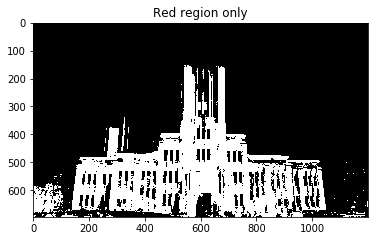

In [16]:
img_mask = np.zeros_like(img_hsv[:,:,0]) # img_hsvと同じサイズの1チャンネルの値0画像を用意

# 色相（H)が30より小さいあるいは160より大きい、彩度(S)が5より大きい画素は255とする
# 閾値はある程度手作業で調整が必要
img_mask[((img_hsv[:,:,0] < 30) | (img_hsv[:,:,0] > 160)) & (img_hsv[:,:,1] > 5)] = 255

# マスクを表示してみましょう
plt.imshow(img_mask, 'gray')
plt.title('Red region only')


### 2.2 輪郭線抽出によってROIの穴をふさぐ

安田講堂のうちレンガではない部分は赤茶色じゃないので、黒く穴が開いていますね。   
そこで、安田講堂部分を包含する輪郭線を抽出し、その中を抜き出します。

領域の輪郭線は、cv2.findContoursという関数で見つけることができます。   
関数[findContours](http://opencv.jp/opencv-2svn/cpp/structural_analysis_and_shape_descriptors.html)は，[Suzuki85](https://www.sciencedirect.com/science/article/pii/0734189X85900167) のアルゴリズムを利用して，2値画像から輪郭を抽出します．   
ここで指定しているフラグは以下の通りです（他のフラグは[こちら](http://opencv.jp/opencv-2svn/cpp/structural_analysis_and_shape_descriptors.html)を参照。)

- CV_RETR_EXTERNAL: 輪郭が入れ子状態になっているとき、最も外側の輪郭のみを抽出します．
- cv2.CHAIN_APPROX_SIMPLE: 水平・垂直・斜めの線分を圧縮し，それらの端点のみを残します．例えば，まっすぐな矩形の輪郭線は，4つの点にエンコードされます．

これによって見つかる輪郭は1つではありません。   
複数の連続するROIがある場合（つまり、繋がっていない領域が複数ある場合）、その領域の数だけ輪郭線が見つかってしまいます。   
今回は、おそらく面積が一番大きい領域が安田講堂の領域でしょうから、面積最大の輪郭を見つけることにしましょう。   
輪郭線の内包する領域の面積はcv2.contourAreaという関数で取り出すことができます。


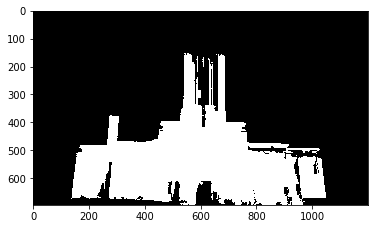

In [17]:
# 輪郭線を抽出
_, contours, hierarchy = cv2.findContours(
    img_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# 面積最大の輪郭線を見つける
max_area = 0
max_index = 0
for i, contour in enumerate(contours):
    if max_area < cv2.contourArea(contour):
        max_index = i
        max_area = cv2.contourArea(contour)

# 面積最大の輪郭線の内部を (255, 255) で塗りつぶす
mask = np.zeros_like(img_rgb[:,:,0]) # 同じサイズの二値画像をマスクとして用意
cv2.drawContours(mask, contours, max_index, color=(255, 255), thickness=-1)

# マスクを見てみよう。穴は埋まりましたか？
# 塔のてっぺんのあたりに穴が開いているのは見逃してください…。
plt.imshow(mask, 'gray')

## 3. 入力画像を前景領域と背景領域に分離

次に原画像にマスクをかけてみましょう。

2.2で作成したマスク`mask`では、前景領域の画素に255、背景領域の画素に0が入っています。   
これを原画像`img_rgb`にかけます。   
これにはcv2.bitwise_andという関数を使います。   
この関数はその名の通り、bitwise(つまり二値で）でand領域（どちらも0でない領域）を取り出します。   

前景はmaskをそのまま使えばいいですね。   
背景は、maskの0と255を入れ替える必要があるので、cv2.bitwise_notを適用します。

Text(0.5, 1.0, 'Background image')

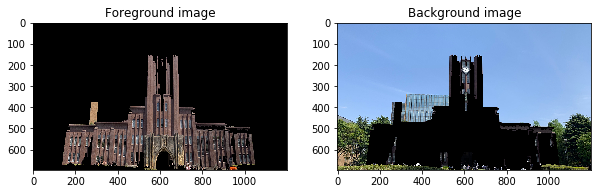

In [18]:
img_foreground = cv2.bitwise_and(img_rgb, img_rgb, mask=mask) # 前景抽出
img_background = cv2.bitwise_and(img_rgb, img_rgb, mask=cv2.bitwise_not(mask)) # 背景抽出

# 前景を描画
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_foreground)
plt.title('Foreground image')

# 背景を描画
plt.subplot(1,2,2)
plt.imshow(img_background)
plt.title('Background image')


## 4. 視差画像を生成
前景領域を赤とシアンに分離し、赤色画像を左に、もしくはシアン画像を右に少しだけずらします。   
行列をずらすにはnp.roll()という関数を使います。   
この関数はその名の通り、指定した数分、値をずらし、溢れた値は反対側に回します。


Text(0.5, 1.0, 'Foreground Cyan')

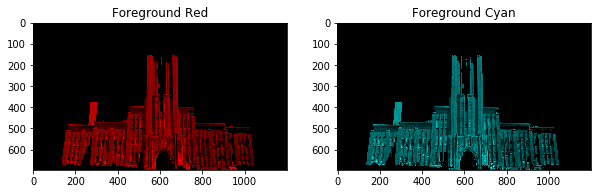

In [27]:
import numpy as np

shift = 3 # 視差はここで調節できます

img_fore_red = np.zeros_like(img_foreground) # img_foregroundと同じサイズの0の画像を用意
img_fore_red[:,:,0] = img_foreground[:,:,0] # 前景画像から赤のチャンネルをとってくる
img_fore_red = np.roll(img_fore_red, -shift, axis=1) # 前景の赤色画像を少しだけ左にずらす

img_fore_cyan = np.zeros_like(img_foreground) # img_foregroundと同じサイズの0の画像を用意
img_fore_cyan[:,:,1] = img_foreground[:,:,1] # 前景画像から緑のチャンネルをとってくる
img_fore_cyan[:,:,2] = img_foreground[:,:,1] # 前景画像から青のチャンネルをとってくる
#img_fore_cyan = np.roll(img_fore_cyan, shift, axis=1) # 背景景の緑画像を少しだけ左にずらす
#img_fore_cyan = np.roll(img_fore_cyan, shift, axis=1) # 背景景の青色画像を少しだけ左にずらす

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img_fore_red)
plt.title('Foreground Red')

plt.subplot(1,2,2)
plt.imshow(img_fore_cyan)
plt.title('Foreground Cyan')


この時点で赤シアンメガネで覗いてみてください。   
赤いフィルタだと赤い画像のみが、シアンのフィルタだとシアンの画像だけが見えているはずです。

## 5. 前景赤色画像、前景シアン画像、背景画像を合成

3枚の画像を足し合わせて元の画像を再合成しましょう。

前景の赤色画像が少しだけ左に、あるいは前景のシアン画像が少しだけ右に動いているので、
これを赤シアン眼鏡（赤が右目）で見ると、前景が飛び出して見えます。

True

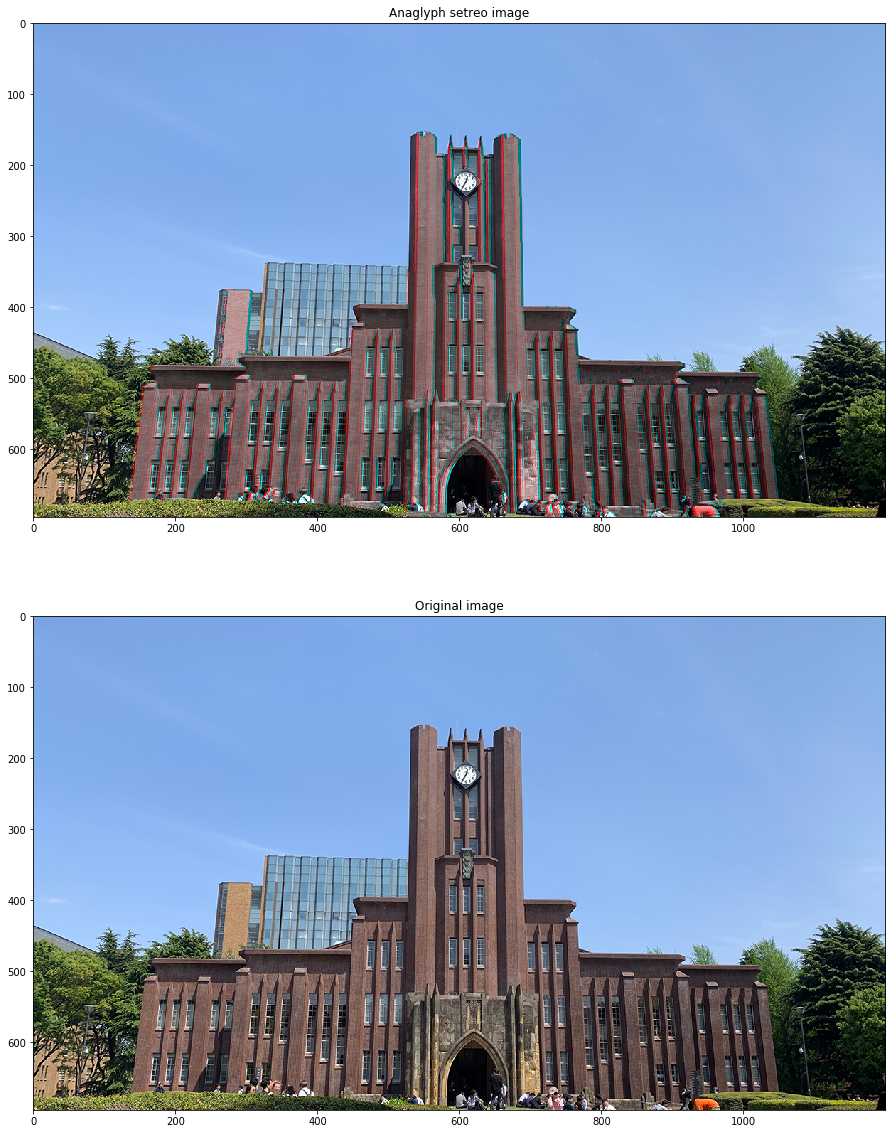

In [28]:
img_anaglyph = np.zeros_like(img_rgb) # img_rgbと同じサイズの値0の画像を用意
img_anaglyph += img_background # 背景画像を足す
img_anaglyph += img_fore_red # 前景赤色画像を足す
img_anaglyph += img_fore_cyan # 前景シアン画像を足す

plt.figure(figsize=(20,20))
plt.subplot(2,1,1)
plt.imshow(img_anaglyph)
plt.title('Anaglyph setreo image')
plt.subplot(2,1,2)
plt.imshow(img_rgb)
plt.title('Original image')

cv2.imwrite('img/anaglyph_img.png', cv2.cvtColor(img_anaglyph, cv2.COLOR_RGB2BGR))